# Consumption and growth rates
The goal of this notebook is to calculate experimental growth rate and experimental substrate uptake rate<br>


<br>
Input: time vs. substrate data and time vs. biomass data
<br>
Output: consumption rate with unit $\frac{mmol substrate consumed}{g biomass*hr}$  and the growth rate with unit hr$^-$$^1$.

### Setup

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress
from scipy import mean
import pymc3 as pm
import theano.tensor as tt
import theano
# from theano import shared

GRAMS_BIOMASS_PER_LITER_PER_OD = 0.35 # 1 OD = 0.35 g/L of biomass

### Yoneda et al. growth curves
Load OD and substrate concentration curves

In [2]:
od_filename = '../../EDD_Yoneda_data/Yoneda_set2_ODD_data.csv'
substrate_filename = '../../EDD_Yoneda_data/Yoneda_set2_Metabolomics_data.csv'

od_df = pd.read_csv(od_filename)
sub_df = pd.read_csv(substrate_filename)

od_df['Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*od_df['Value']

print(f'substrate data has {len(sub_df)} lines')
print(f'OD data has {len(od_df)} lines')

substrate data has 84 lines
OD data has 63 lines


### Define fuction to prepare data
Take in od and sub dfs and trial names and max time and output a dataframe with only those 

In [5]:
def stats_for_condtion(od_df, sub_df, trial_1, trial_2, trial_3, molar_mass, max_time=0):
    
    # remove values past a certain time. This step can remove stationary phase data points
    if max_time != 0:
        od_df = od_df[od_df['Time'] < max_time]
        sub_df = sub_df[sub_df['Time'] < max_time]
        
        
    # convert substrate concentration from g/L to mmol/L
    sub_df['Substrate Conc'] = sub_df['Value']*1000/molar_mass
    
    # only use values for the condition in question
    od_df = od_df[od_df['Line Name'].isin([trial_1, trial_2, trial_3])]
    sub_df = sub_df[sub_df['Line Name'].isin([trial_1, trial_2, trial_3])]
    
    # get starting values for OD and substrate conc
    biomass_init = np.average(od_df[od_df['Time'] == 0]['Biomass Conc'])
    substrate_init = np.average(sub_df[sub_df['Time'] == 0]['Substrate Conc'])
    
    # get time values to predict for OD and substrate conc
    od_times = np.array(od_df['Time'])
    sub_times = np.array(sub_df['Time'])
    
    # get list of time values and measured data. This will be used as input and observed data in the pymc3 model
#     obs_y = np.append(np.array(od_df['Biomass Conc']), np.array(list(sub_df['Substrate Conc'])))
    obs_y = np.array(od_df['Biomass Conc'])
    obs_y2 = np.array(sub_df['Substrate Conc'])
    
    # define Euler's number since math.exp throws an error
    e = 2.718281
    
    with pm.Model() as model:

        growth_rate = pm.HalfNormal('growth_rate', sd=0.075)
        yield_coeff = pm.HalfNormal('yield_coeff', sd=0.05)
        error = pm.HalfNormal('error', sd=0.1)
        
        biomass = biomass_init * e**(growth_rate * od_times)

#         substrate = starting_value - (substrate used / g biomass made) * (biomass generated)
        substrate = substrate_init - yield_coeff * biomass_init * (e**(growth_rate * sub_times) - 1)

        
#         expected_output = pm.math.concatenate([biomass, substrate], axis=0)
#         expected_output = tt.stack([biomass, substrate], axis=0)
        expected_output = biomass
        

        y = pm.Normal('y', mu=biomass, sd=error, observed=obs_y)  
        y2 = pm.Normal('y2', mu=substrate, sd=error, observed=obs_y2)  
        trace = pm.sample(2000, tune=10000)

        pm.traceplot(trace, ['growth_rate', 'yield_coeff', 'error'])
        plt.show()
        
        ppc = pm.sample_ppc(trace, samples=1000)
        y_preds = ppc['y'] 

        # y_preds has shape 1000 by 10000
        print(y_preds.shape)
        #for each sample of the posterior (1000 total) predict all y values (10000 in total)

        # Taking the mean, you find the mean of the 1000 samples for all values of y
        # resulting thing is a vector with shape 1 by 10000
        print(np.reshape(np.mean(y_preds, axis=0), [-1]))
        
        expected_y_pred = np.reshape(np.mean(y_preds, axis=0), [-1])
        
        print(expected_y_pred)

        plt.scatter(od_times, list(expected_y_pred)[:len(od_times)], c='g')
        plt.scatter(od_times, obs_y[:len(od_times)], c='b', alpha=0.5)
#         plt.scatter(sub_times, list(expected_y_pred)[len(od_times):], c='r')
#         plt.scatter(sub_times, obs_y[len(od_times):], c='k', alpha=0.5)
        plt.title('Relationship between X and predicted Y')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, yield_coeff, growth_rate]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:16<00:00, 1002.26draws/s]
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 788 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5157045483308189, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 228 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6645855464867766, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/share/jupyteruser/.pyenv/versions/ART

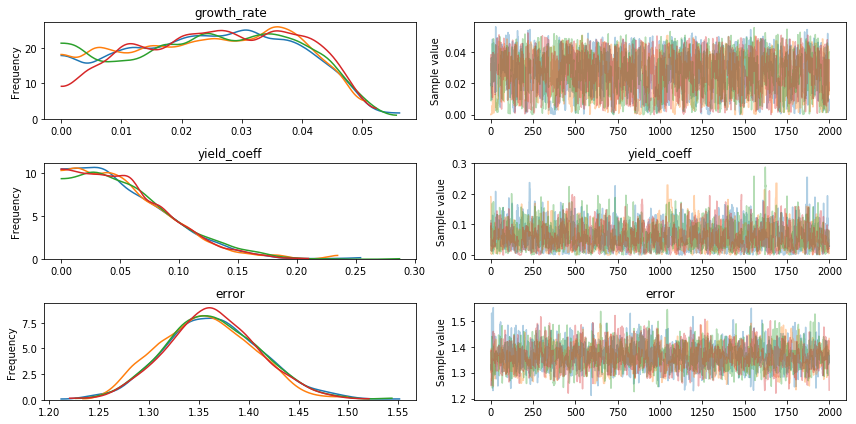

100%|██████████| 1000/1000 [00:01<00:00, 628.92it/s]


(1000, 15)
[0.09618404 0.18251939 0.37664451 0.48826481 0.69493016 0.00148167
 0.13623751 0.40090844 0.51733211 0.68690258 0.1117335  0.09754096
 0.2722689  0.45695052 0.68285226]
[0.09618404 0.18251939 0.37664451 0.48826481 0.69493016 0.00148167
 0.13623751 0.40090844 0.51733211 0.68690258 0.1117335  0.09754096
 0.2722689  0.45695052 0.68285226]


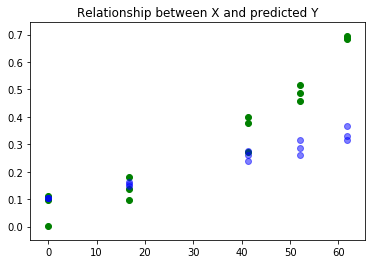

In [6]:
stats_for_condtion(od_df, sub_df, 'WT-R1', 'WT-R2', 'WT-R3', 94.11)

### Now predict data
Use posterior predictive check

In [199]:
with model:
#     posterior predictive check
    ppc = pm.sample_ppc(trace, samples=1000)
    y_preds = ppc['y'] 
    
    # y_preds has shape 1000 by 10000
    print(y_preds.shape)
    #for each sample of the posterior (1000 total) predict all y values (10000 in total)
    
    # Taking the mean, you find the mean of the 1000 samples for all values of y
    # resulting thing is a vector with shape 1 by 10000
    expected_y_pred = np.reshape(np.mean(y_preds, axis=0), [-1])
    
    plt.scatter(X, expected_y_pred, c='g')
    plt.scatter(X, obs_y, c='b', alpha=0.1)
    plt.title('Relationship between X and predicted Y')

NameError: name 'model' is not defined

### Define function that gets the parameter values and variance

In [ ]:
def stats_for_trial(growth_data, substrate_data, molar_mass, display=False):
    
    biomass_values = growth_data['Biomass Conc']
    biomass_times = growth_data['Time']
    biomass_init = list(biomass_values)[0]

    substrate_values = substrate_data['Value']*1000/molar_mass
    substrate_times = substrate_data['Time']
    substrate_init = list(substrate_values)[0]
    
    # growth is the slope of log(biomass) vs. time
    growth_rate, _, _, _, _ = linregress(biomass_times, [math.log(val) for val in biomass_values])
    
    # biomass X = X0*e^(μ*t)
    biomass_sim = [biomass_init*math.exp(growth_rate*time) for time in biomass_times]
    
    # actual consumption = S0 - S
    sub_consumed = [substrate_init - sub_value for sub_value in substrate_values]
    
    # new biomass X = X0 - X
    biomass_sim_growth = [sim_value - biomass_init for sim_value in biomass_sim ]
    
    # yield is the amount of biomass that can be made from a mmol of substrate
    yield_coeff, _, _, _, _ = linregress(sub_consumed, biomass_sim_growth)

    # S = S0 - (1/yield)*X
    substrate_sim = [substrate_init - 1/yield_coeff*val for val in biomass_sim_growth]
    
    # units work out to mmol substrate consumed / (g biomass * hr)
    substrate_consumption_rate = (1/yield_coeff) * growth_rate

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
    axes[0].plot(biomass_times, biomass_values, 'o', color='black')
    axes[0].plot(biomass_times, biomass_sim, '-', color='black')
    axes[1].plot(substrate_times, substrate_values, 'o', color='blue')
    axes[1].plot(substrate_times, substrate_sim, '-', color='blue')
    axes[0].set_title('Biomass growth')
    axes[1].set_title('Phenol consumption')
    axes[0].set_xlabel('Time (hr)')
    axes[1].set_xlabel('Time (hr)')
    axes[0].set_ylabel('Biomass (g/L)')
    axes[1].set_ylabel('Phenol (mmol/L)')
    fig.tight_layout()
    
    if display:
        print(f'growth_rate = {growth_rate:.3f} hr-1')
        print(f'yield coefficient = {yield_coeff:.3f} g biomass / mmol substrate')
        print(f'substrate consumption rate = {substrate_consumption_rate:.3f} mmol substrate/gram biomass * hr')
    else:
        return growth_rate, yield_coeff, substrate_consumption_rate

### pymc3 exercises

In [ ]:
obs_y = np.random.normal(0.5, 0.4, 10)

In [ ]:
with pm.Model() as excercise1:
    stdev = pm.HalfNormal('stdev', tau=1)
    mu = pm.Normal('mu', mu=0.0, sd=1)
    
    y = pm.Normal('y', mu=mu, sd=stdev, observed=obs_y)
    
    trace = pm.sample(1000)
    
    pm.traceplot(trace, ['mu', 'stdev'])
    plt.show()
    

### Linear regression Exercise 2

<class 'numpy.ndarray'>


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept, stdev]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:35<00:00, 561.01draws/s]
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


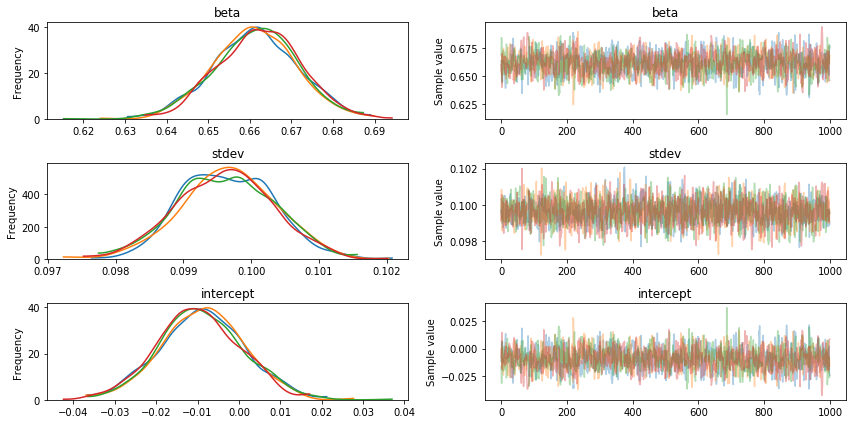

In [50]:
N = 10000

noise = np.random.normal(0.0, 0.1, N)
# noise = np.random.normal(0.0, 0.1, N)
X = np.random.normal(1.0, 0.1, N)

print(type(X))
obs_y = (0.65 * X) + noise

with pm.Model() as exercise2:
    
    stdev = pm.HalfNormal('stdev', sd=1.)
    intercept = pm.Normal('intercept', mu=0.0, sd=2.)
    coeff = pm.Normal('beta', mu=0.5, sd=2.)
    
    expected_value = (X * coeff) + intercept
    y = pm.Normal('y', mu=expected_value, sd=stdev, observed=obs_y)  #how is x being passed in here?
    
    trace = pm.sample(1000, tune=4000)
    
    pm.traceplot(trace, ['beta', 'stdev', 'intercept'])
    plt.show()

How to predict data

In [ ]:
with exercise2:
#     posterior predictive check
    ppc = pm.sample_ppc(trace, samples=1000)
    y_preds = ppc['y'] 
    
    # y_preds has shape 1000 by 10000
    print(y_preds.shape)
    #for each sample of the posterior (1000 total) predict all y values (10000 in total)
    
    # Taking the mean, you find the mean of the 1000 samples for all values of y
    # resulting thing is a vector with shape 1 by 10000
    expected_y_pred = np.reshape(np.mean(y_preds, axis=0), [-1])
    
    plt.scatter(X, expected_y_pred, c='g')
    plt.scatter(X, obs_y, c='b', alpha=0.1)
    plt.title('Relationship between X and predicted Y')

### Exercise 3: Logistic regression

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:11<00:00, 513.58draws/s]
The acceptance probability does not match the target. It is 0.8818279892074808, but should be close to 0.8. Try to increase the number of tuning steps.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


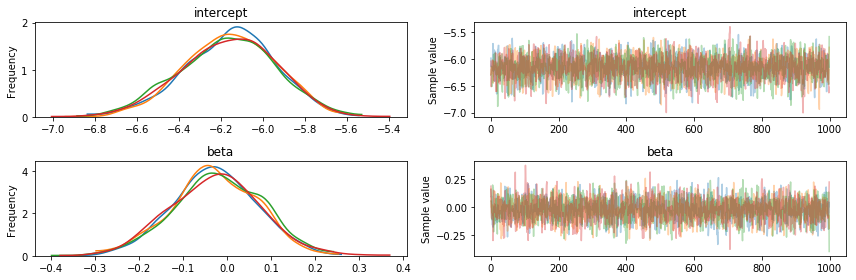

100%|██████████| 500/500 [00:00<00:00, 1253.31it/s]


(500, 1000)


Text(0.5, 1.0, 'Relation between X and (predicted) Y')

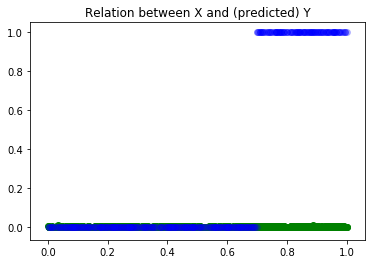

In [248]:
# fits binary data

N = 10000

X = np.random.uniform(0,1,N)
# DGP = ?
def DGP(x):
    obs_y = []
    for n in range(len(x)):
        if x[n] > (0.7 + np.random.normal(0.0, 0.0001, 1)[0]):
            obs_y.append(1)
        else:
            obs_y.append(0)
    return obs_y

# what does this do? 
# This makes it possible to switch out test and train X variable
X_shared = theano.shared(X)

with pm.Model() as exercise3:

    intercept = pm.Normal('intercept', mu=0.0, sd=1.)
    coeff = pm.Normal('beta', mu=0.0, sd=0.1)
    
    expected_value = pm.math.invlogit(coeff * X_shared + intercept)
    y = pm.Bernoulli('y', expected_value, observed=obs_y)
    
    trace = pm.sample(1000)
    
    pm.traceplot(trace, ['intercept', 'beta'])
    plt.show()

TEST_N = 1000
testX = np.random.uniform(0, 1, TEST_N)
testY = DGP(testX)

X_shared.set_value(testX)

ppc = pm.sample_ppc(trace, model=exercise3, samples=500)
y_preds = ppc['y']

print(y_preds.shape)

expected_y_pred = np.reshape(np.mean(y_preds, axis=0), [-1])

plt.scatter(testX, expected_y_pred, c='g')
plt.scatter(testX, testY, c='b', alpha=0.1)
plt.title('Relation between X and (predicted) Y')

### Exercise 4: Hierarchical models
Stocks and industry sectors

Question: what is daily return of energy sector, and how does it relate to individual stocks?

In [260]:
N = 100
NUM_FACTORS = 15
N_PER_FACTOR = N/NUM_FACTORS

COMMON_BETA_MU = 5.6 # coefficient
COMMON_ALPHA_MU = 1.0 # intercept
COMMON_SD = 0.1 # standard deviation of both coefficient and intercept

factors = []
for _ in range(NUM_FACTORS):
    Bmu = np.random.normal(COMMON_BETA_MU, COMMON_SD)
    Amu = np.random.normal(COMMON_ALPHA_MU, COMMON_SD)
    
    factors.append([Amu, Bmu])
    
Y = None
X = None
factor_indicies = None

# loops 15 times
for f_idx, f in enumerate(factors):
    innovation = np.reshape(np.random.normal(0.0, 0.01, int(N_PER_FACTOR)), [-1, 1])
    
    indicies = np.ones_like(innovation) * f_idx
    
    # f[1] = slope f[0] = intercept
    y = (f[1] * innovation) + f[0]
    
    if X is None:
        X = innovation
        factor_indicies = indicies
        Y = y
    else:
        X = np.concatenate((X, innovation), axis=0)
        factor_indicies = np.concatenate((factor_indicies, indicies), axis=0)
        Y = np.concatenate((Y,y), axis=0)
        
X_shared = theano.shared(X)
Y_shared = theano.shared(Y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:04<00:00, 3264.69draws/s]
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


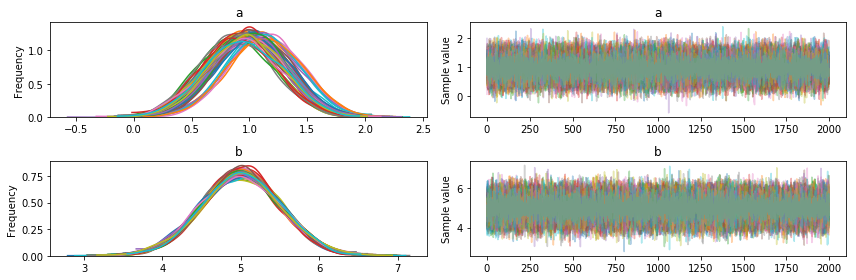

100%|██████████| 2000/2000 [00:33<00:00, 58.85it/s]


(2000, 90, 1)
(90, 1)


In [261]:
with pm.Model() as exercise4_unpooled:
    a = pm.Normal('a', mu=1, sd=.5, shape=NUM_FACTORS) # this is a vector of intercepts with length 15
    b = pm.Normal('b', mu=5, sd=.5, shape=NUM_FACTORS) # this is a vector of slopes with length 15
    
    expected_value = (b[factor_indicies.astype(int)] * X_shared) + a[factor_indicies.astype(int)] # this is a vector of y's with length 15
    y = pm.Normal('y', expected_value, observed=Y_shared)
    
    trace = pm.sample(2000, tune=2000)
    
    pm.traceplot(trace, ['a', 'b'])
    plt.show()
    
samples = pm.sample_ppc(trace, model=exercise4_unpooled, size=1000)
y_preds = np.mean(samples['y'], axis=1)

print(y_preds.shape)
print(Y.shape)

In [262]:
RMSD = np.sqrt(np.mean((y_preds - Y)**2.0))
print(RMSD)

0.32086521975431365


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:59<00:00, 270.26draws/s] 
There were 1761 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.07130508205586912, but should be close to 0.8. Try to increase the number of tuning steps.
There were 580 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6000611172391805, but should be close to 0.8. Try to increase the number of tuning steps.
There were 309 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7132980173456748, but should be close to 0.8. Try to increase the number of tuning steps.
There were 391 divergences after tuning. Increa

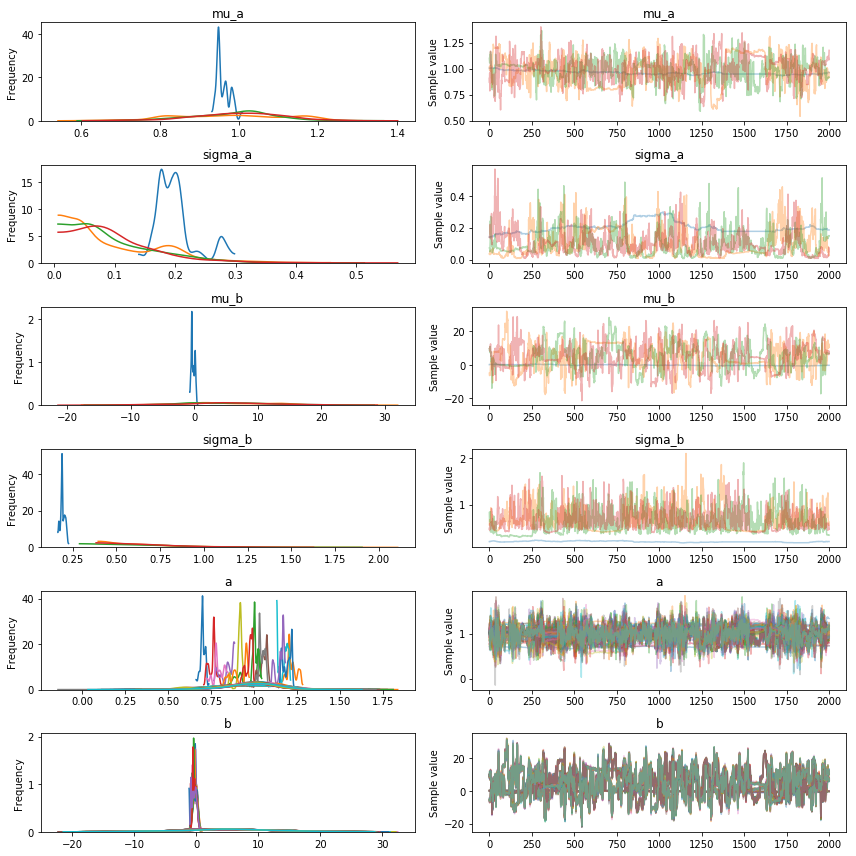

In [263]:
with pm.Model() as exercise4_pooled:
    
    
    # These top level factors are used to parameterize of individual factors
    mu_a = pm.Normal('mu_a', 1, sd=10, shape = 1)
    sigma_a = pm.HalfNormal('sigma_a', sd=0.5)
    mu_b = pm.Normal('mu_b', 5, sd=10, shape = 1)
    sigma_b = pm.HalfNormal('sigma_b', sd=0.5)
    
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape = NUM_FACTORS)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape = NUM_FACTORS)
    
    expected_value = (b[factor_indicies.astype(int)] * X_shared) + a[factor_indicies.astype(int)]
    y = pm.Normal('y', expected_value, observed=Y_shared)
    
    trace = pm.sample(2000, tune = 2000)
    
    pm.traceplot(trace, ['mu_a', 'sigma_a', 'mu_b', 'sigma_b', 'a', 'b'])
    plt.show()

In [264]:
samples = pm.sample_ppc(trace, model=exercise4_pooled, size=1000)
y_preds = np.mean(samples['y'], axis=1)

RMSD = np.sqrt(np.mean((y_preds - Y) ** 2.0))
print(RMSD)

100%|██████████| 2000/2000 [00:32<00:00, 60.78it/s]


0.2133059808012388


### Pooled model has higher accuracy that the unpooled model. Why? <br>
Despite having variables that do not fit as well, the hierarchical model is less sensitive to random effects.<br>
<br>
Has to do with 'shrinkage'. By pulling individual factor into a common factor.<br>
Has a regularizing effect. If there are outliers for a given sample it will be pulled towards the mean.<br>
'Shrinkage' cause the parameters to move closer together towards the group mean.

### Exercise 5: Neural Networks

(1000, 1)


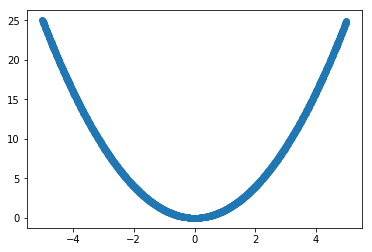

In [269]:
X = np.reshape(np.arange(-5.0, 5.0, 0.01), [-1,1])

print(X.shape)

Y = X ** 2

plt.scatter(X,Y)
plt.show()

# these are shared variables whose initial value is X or Y
ann_input = theano.shared(X) 
ann_output = theano.shared(Y)

n_hidden = 5


# initialize weights in neural network
# each on the inputs has a weight connected to each of the first layer of hidden nodes
init_1 = np.random.randn(X.shape[1], n_hidden).astype(theano.config.floatX)
# each node in the first layer has a weight connected to the second layer
init_2 = np.random.randn(n_hidden, n_hidden).astype(theano.config.floatX)
# each node from the second layer has a single weight connected to the output
init_out = np.random.randn(n_hidden, 1).astype(theano.config.floatX)

SD = 10
with pm.Model() as neural_network:
    
    weights_1 = pm.Normal('layer1', mu=0, sd=SD, shape=(X.shape[1], n_hidden), testval = init_1) # shape = 1 by 5
    bias_1 = pm.Normal('bias1', mu=0, sd=SD, shape = n_hidden) # shape = vector length 5
    weights_2 = pm.Normal('layer2', mu=0, sd=SD, shape=(n_hidden, n_hidden), testval = init_2) # shape = 5 by 5
    bias_2 = pm.Normal('bias2', mu=0, sd=SD, shape = n_hidden) # shape = vector length 5
    weights_out = pm.Normal('out', mu=0, sd=SD, shape= (n_hidden, 1), testval = init_out) 
    intercept = pm.Normal('intercept', mu=0, sd=SD)
    
    layer_1 = pm.math.tanh(pm.math.dot(ann_input, weights_1) + bias_1) # output will be 1000 x 5
    layer_2 = pm.math.tanh(pm.math.dot(layer_1, weights_2) + bias_2) # output will be 1000 x 5
    layer_out = pm.math.tanh(pm.math.dot(layer_2, weights_out))
    
    y = pm.Normal('y', layer_out + intercept, observed = ann_output)

In [273]:
num_samples = 200
with neural_network:
    trace = pm.sample(num_samples, tune = num_samples, nuts_kwargs=dict(target_accept=0.999))
    
samples = pm.sample_ppc(trace, model=neural_network, size=500)

y_preds = np.reshape(samples['y'], [num_samples, 500, X.shape[0]])

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, out, bias2, layer2, bias1, layer1]
Sampling 4 chains: 100%|██████████| 1600/1600 [03:43<00:00,  1.27draws/s]
The acceptance probability does not match the target. It is 0.9855953277361986, but should be close to 0.999. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8889459319331304, but should be close to 0.999. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not ma

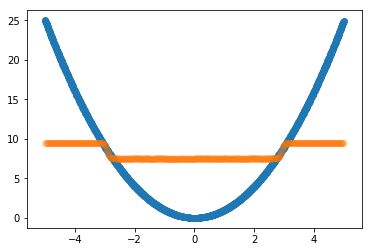

In [274]:
# get the average, since we're interested in plotting the expectation.
y_preds = np.mean(y_preds, axis=1)
y_preds = np.mean(y_preds, axis=0)

RMSD = np.sqrt(np.mean((y_preds - Y) ** 2.0))

plt.scatter(X, Y)
plt.scatter(X, y_preds, alpha=0.1)
plt.show()

### Yoneda et al. growth curves
Load OD and substrate concentration curves

In [ ]:
od_filename = '../../EDD_Yoneda_data/Yoneda_set2_ODD_data.csv'
substrate_filename = '../../EDD_Yoneda_data/Yoneda_set2_Metabolomics_data.csv'

od_df = pd.read_csv(od_filename)
sub_df = pd.read_csv(substrate_filename)

od_df['Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*od_df['Value']

print(f'substrate data has {len(sub_df)} lines')
print(f'OD data has {len(od_df)} lines')

### Define function that takes in a single trial and returns growth rate and substrate yield

In [ ]:
def stats_for_trial(growth_data, substrate_data, molar_mass, display=False):
    
    biomass_values = growth_data['Biomass Conc']
    biomass_times = growth_data['Time']
    biomass_init = list(biomass_values)[0]

    substrate_values = substrate_data['Value']*1000/molar_mass
    substrate_times = substrate_data['Time']
    substrate_init = list(substrate_values)[0]
    
    # growth is the slope of log(biomass) vs. time
    growth_rate, _, _, _, _ = linregress(biomass_times, [math.log(val) for val in biomass_values])
    
    # biomass X = X0*e^(μ*t)
    biomass_sim = [biomass_init*math.exp(growth_rate*time) for time in biomass_times]
    
    # actual consumption = S0 - S
    sub_consumed = [substrate_init - sub_value for sub_value in substrate_values]
    
    # new biomass X = X0 - X
    biomass_sim_growth = [sim_value - biomass_init for sim_value in biomass_sim ]
    
    # yield is the amount of biomass that can be made from a mmol of substrate
    yield_coeff, _, _, _, _ = linregress(sub_consumed, biomass_sim_growth)

    # S = S0 - (1/yield)*X
    substrate_sim = [substrate_init - 1/yield_coeff*val for val in biomass_sim_growth]
    
    # units work out to mmol substrate consumed / (g biomass * hr)
    substrate_consumption_rate = (1/yield_coeff) * growth_rate

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
    axes[0].plot(biomass_times, biomass_values, 'o', color='black')
    axes[0].plot(biomass_times, biomass_sim, '-', color='black')
    axes[1].plot(substrate_times, substrate_values, 'o', color='blue')
    axes[1].plot(substrate_times, substrate_sim, '-', color='blue')
    axes[0].set_title('Biomass growth')
    axes[1].set_title('Phenol consumption')
    axes[0].set_xlabel('Time (hr)')
    axes[1].set_xlabel('Time (hr)')
    axes[0].set_ylabel('Biomass (g/L)')
    axes[1].set_ylabel('Phenol (mmol/L)')
    fig.tight_layout()
    
    if display:
        print(f'growth_rate = {growth_rate:.3f} hr-1')
        print(f'yield coefficient = {yield_coeff:.3f} g biomass / mmol substrate')
        print(f'substrate consumption rate = {substrate_consumption_rate:.3f} mmol substrate/gram biomass * hr')
    else:
        return growth_rate, yield_coeff, substrate_consumption_rate

### Define function to calculate growth_rate, yield coefficient, and substrate consumption for a given condition
take in 3 trial names and molar mass, and output growth rate, yield coefficients, and substrate consumption rate

In [ ]:
def stats_for_condtion(od_df, sub_df, trial_1, trial_2, trial_3, molar_mass, max_time=0):
    
    if max_time != 0:
        od_df = od_df[od_df['Time'] < max_time]
        sub_df = sub_df[sub_df['Time'] < max_time]
        
    od_1 = od_df[od_df['Line Name'] == trial_1]
    sub_1 = sub_df[sub_df['Line Name'] == trial_1]

    od_2 = od_df[od_df['Line Name'] == trial_2]
    sub_2 = sub_df[sub_df['Line Name'] == trial_2]

    od_3 = od_df[od_df['Line Name'] == trial_3]
    sub_3 = sub_df[sub_df['Line Name'] == trial_3]

    gr_1, yc_1, scr_1 = stats_for_trial(od_1, sub_1, molar_mass)
    gr_2, yc_2, scr_2 = stats_for_trial(od_2, sub_2, molar_mass)
    gr_3, yc_3, scr_3 = stats_for_trial(od_3, sub_3, molar_mass)

    print(f'growth_rate = {np.average([gr_1, gr_2, gr_3]):.3f} ± {np.std([gr_1, gr_2, gr_3]):.3f} hr-1')
    print(f'yield coefficient = {np.average([yc_1, yc_2, yc_3]):.3f} ± {np.std([yc_1, yc_2, yc_3]):.3f} g biomass / mmol substrate')
    print(f'substrate consumption rate = {np.average([scr_1, scr_2, scr_3]):.3f} ± {np.std([scr_1, scr_2, scr_3]):.3f} mmol substrate/gram biomass * hr')

### Stats for WT phenol condition

In [ ]:
stats_for_condtion(od_df, sub_df, 'WT-R1', 'WT-R2', 'WT-R3', 94.11)

### Stats for Evol33 phenol condition

In [ ]:
stats_for_condtion(od_df, sub_df, 'EVOL33-R1', 'EVOL33-R2', 'EVOL33-R3', 94.11, max_time=60)

### Stats for Evol40 phenol condition

In [ ]:
stats_for_condtion(od_df, sub_df, 'EVOL40-R1', 'EVOL40-R2', 'EVOL40-R3', 94.11,  max_time=60)

### Glucose data looks wrong. 
Why is starting concentration ~0.05 g/L? This is much too low to be reasonable

### Stats for WT glucose condition

In [ ]:
od_1 = od_df[od_df['Line Name'] == 'WT-G']
sub_1 = sub_df[sub_df['Line Name'] == 'WT-G']

stats_for_trial(od_1, sub_1, 180.16, display=True)

### Stats for Evol33 glucose condition

In [ ]:
od_1 = od_df[od_df['Line Name'] == 'EVOL33-G']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL33-G']
stats_for_trial(od_1, sub_1, 180.16, display=True)

### Stats for Evol40 glucose condition

In [ ]:
od_1 = od_df[od_df['Line Name'] == 'EVOL40-G']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL40-G']
stats_for_trial(od_1, sub_1, 180.16, display=True)

### Stats for low N WT glucose condition

In [ ]:
od_1 = od_df[od_df['Line Name'] == 'WT-G-N']
sub_1 = sub_df[sub_df['Line Name'] == 'WT-G-N']
stats_for_trial(od_1, sub_1, 180.16, display=True)

### Stats for low N Evol33 glucose condition

In [ ]:
od_1 = od_df[od_df['Line Name'] == 'EVOL33-G-N']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL33-G-N']
stats_for_trial(od_1, sub_1, 180.16, display=True)

### Stats for low N Evol40 glucose condition

In [ ]:
od_1 = od_df[od_df['Line Name'] == 'EVOL40-G-N']
sub_1 = sub_df[sub_df['Line Name'] == 'EVOL40-G-N']
stats_for_trial(od_1, sub_1, 180.16, display=True)

## Henson Data
Load OD and substrate concentration curves

In [ ]:
od_filename = '../../EDD_Henson_data/Henson_ODD_data.csv'
substrate_filename = '../../EDD_Henson_data/Henson_metabolomics_data.csv'

od_df = pd.read_csv(od_filename)
sub_df = pd.read_csv(substrate_filename)

od_df['Biomass Conc'] = GRAMS_BIOMASS_PER_LITER_PER_OD*od_df['Value']

print(f'substrate data has {len(sub_df)} lines')
print(f'OD data has {len(od_df)} lines')

In [ ]:
def stats_for_trial(growth_data, substrate_data, molar_mass, display=False, max_time=0):
    
    biomass_values = growth_data['Biomass Conc']
    biomass_times = growth_data['Time']
    biomass_init = list(biomass_values)[0]

    substrate_values = substrate_data['Value']*1000/molar_mass
    substrate_times = substrate_data['Time']
    substrate_init = list(substrate_values)[0]
    
    # growth is the slope of log(biomass) vs. time
    growth_rate, _, _, _, _ = linregress(biomass_times, [math.log(val) for val in biomass_values])
    
    # biomass X = X0*e^(μ*t)
    # This is different from above to ensure that there is a biomass value for every substrate measurement
    biomass_sim = [biomass_init*math.exp(growth_rate*time) for time in substrate_times]
    
    # actual consumption = S0 - S
    sub_consumed = [substrate_init - sub_value for sub_value in substrate_values]
    
    # new biomass X = X0 - X
    biomass_sim_growth = [sim_value - biomass_init for sim_value in biomass_sim ]
    
    # yield is the amount of biomass that can be made from a mmol of substrate
    yield_coeff, _, _, _, _ = linregress(sub_consumed, biomass_sim_growth)

    # S = S0 - (1/yield)*X
    substrate_sim = [substrate_init - 1/yield_coeff*val for val in biomass_sim_growth]
    
    substrate_consumption_rate = (1/yield_coeff) * growth_rate

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
    axes[0].plot(biomass_times, biomass_values, 'o', color='black')
    axes[0].plot(substrate_times, biomass_sim, '-', color='black')
    axes[1].plot(substrate_times, substrate_values, 'o', color='blue')
    axes[1].plot(substrate_times, substrate_sim, '-', color='blue')
    axes[0].set_title('Biomass growth')
    axes[1].set_title('Phenol consumption')
    axes[0].set_xlabel('Time (hr)')
    axes[1].set_xlabel('Time (hr)')
    axes[0].set_ylabel('Biomass (g/L)')
    axes[1].set_ylabel('Phenol (mmol/L)')
    fig.tight_layout()
    
    if display:
        print(f'growth_rate = {growth_rate:.3f} hr-1')
        print(f'yield coefficient = {yield_coeff:.3f} g biomass / mmol substrate')
        print(f'substrate consumption rate = {substrate_consumption_rate:.3f} mmol substrate/gram biomass * hr')
    else:
        return growth_rate, yield_coeff, substrate_consumption_rate

In [ ]:
stats_for_condtion(od_df, sub_df,'WT-P-R1', 'WT-P-R2', 'WT-P-R3', 94.11, max_time = 40)

In [ ]:
stats_for_condtion(od_df, sub_df, 'PVHG6-P-R1', 'PVHG6-P-R2', 'PVHG6-P-R3', 94.11, max_time=40)